In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
import string



# Preprocessed  Tweets Data

In [ ]:
# Load the dataset
df = pd.read_csv('/content/processed_tweets.csv')

In [ ]:
# View first few rows
print("\nSample Data:")
print(df.head())



Sample Data:
   Index                                     processed_text
0      0  dear bjp , please read usershashitharoor tweet...
1      1  oh ye nai ho sakta mt usersonykalloor number b...
2      2  minority towards bjp modi . repeat ji . repeat...
3      3  bjp afraid usershashitharoor think braveheart ...
4      4    every girl beautiful boyz . repeat reject . sad


In [ ]:
df['word_count'] = df['processed_text'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)


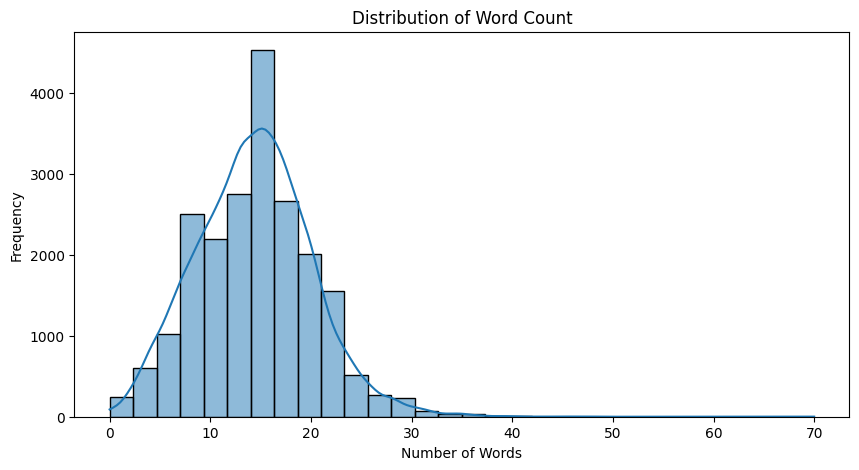

In [ ]:
# Plot word count distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['word_count'], bins=30, kde=True)
plt.title('Distribution of Word Count')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

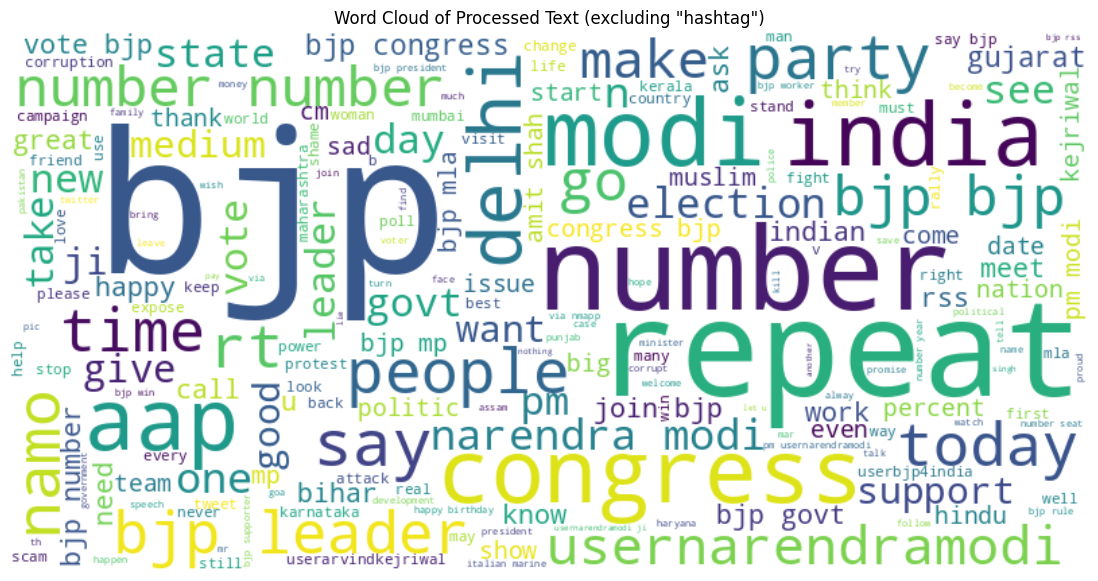

In [ ]:
from wordcloud import WordCloud, STOPWORDS
custom_stopwords = set(STOPWORDS)
custom_stopwords.add('hashtag')

# Prepare the text
all_words = ' '.join(df['processed_text'].fillna('').astype(str))

# Generate the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=custom_stopwords
).generate(all_words)

# Plot the word cloud
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Processed Text (excluding "hashtag")')
plt.show()


In [ ]:
# Most common words (excluding stopwords)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
all_tokens = all_words.lower().translate(str.maketrans('', '', string.punctuation)).split()
filtered_tokens = [word for word in all_tokens if word not in stop_words]

word_freq = Counter(filtered_tokens)
common_words = word_freq.most_common(20)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


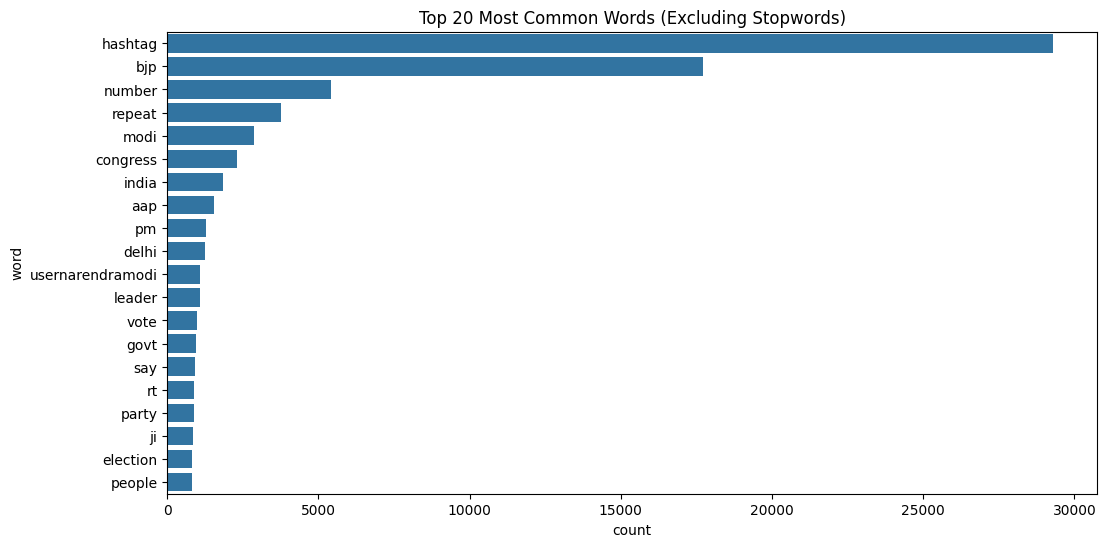

In [ ]:
# Plot most common words
common_df = pd.DataFrame(common_words, columns=['word', 'count'])
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='word', data=common_df)
plt.title('Top 20 Most Common Words (Excluding Stopwords)')
plt.show()

# Sentiment Scores of Preprocessed  Tweets

In [ ]:
df = pd.read_csv('/content/reshaped_all_tweet_score(2013-2018).csv')

In [ ]:
df.head()

,Retweets,Likes,bertweet_score,cardiff_score,vader_score
datetime,,,,,
2013-01-01 00:00:00,0.0,0.0,0.113106,0.259274,0.27060
2013-01-01 02:24:00,0.0,0.0,0.496756,0.466894,0.69090
2013-01-01 04:48:00,0.0,0.0,0.084343,0.222480,0.15960
2013-01-01 07:12:00,0.0,0.0,0.502342,0.416070,0.50000
2013-01-01 09:36:00,6.0,1.0,0.073976,0.138584,0.22885


In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [ ]:

# Extract the year from the 'datetime' column
df['year'] = df['datetime'].dt.year

# Get unique years
unique_years = df['year'].unique()

print("Unique Years:", unique_years)

Unique Years: [2013 2014 2015 2016 2017 2018]


In [ ]:
df.set_index('datetime', inplace=True)

In [ ]:
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 Retweets            0
Likes               0
Index               0
bertweet_score      0
cardiff_score       0
distilbert_score    0
vader_score         0
dtype: int64


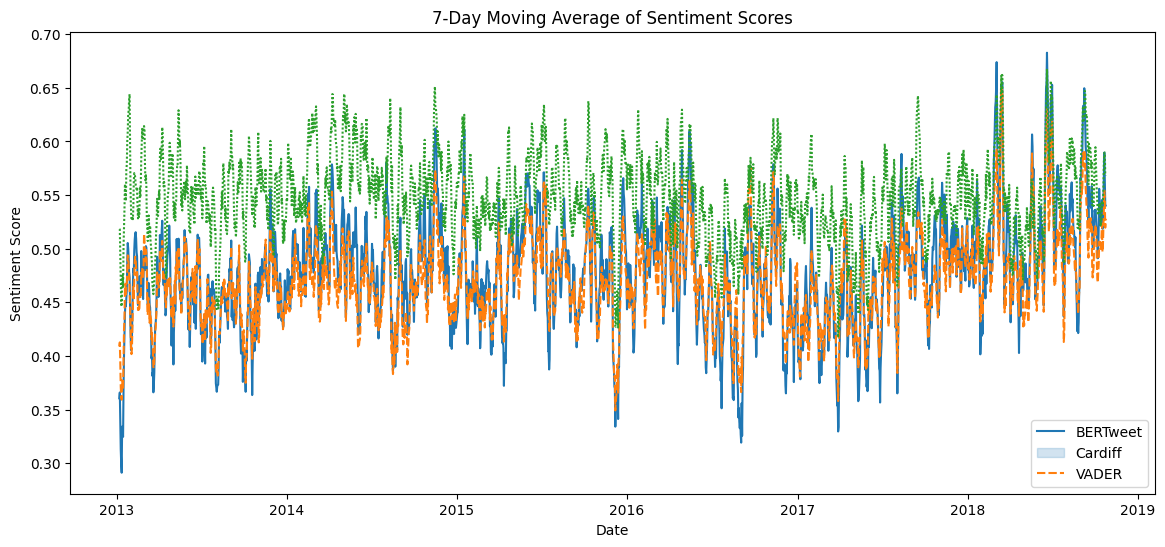

In [ ]:
# ========== moving Average: 7-Day Smooth ==========
rolling_sentiment = daily_sentiment.rolling(window=7).mean()

plt.figure(figsize=(14,6))
sns.lineplot(data=rolling_sentiment)
plt.title('7-Day Moving Average of Sentiment Scores')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend(['BERTweet', 'Cardiff', 'VADER'])
plt.show()

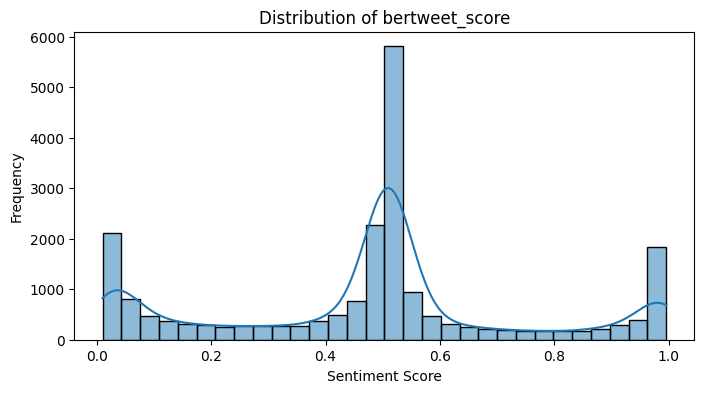

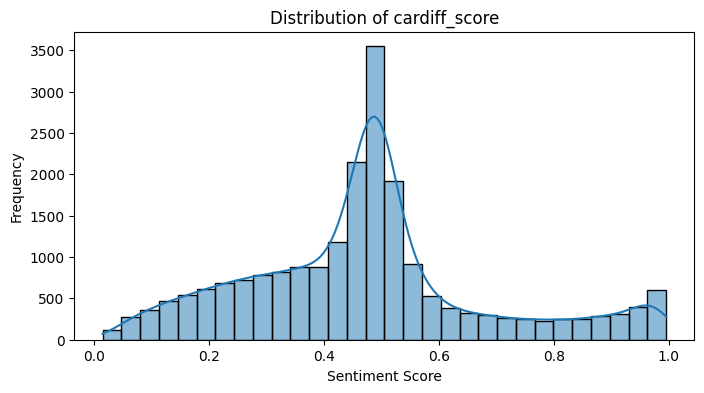

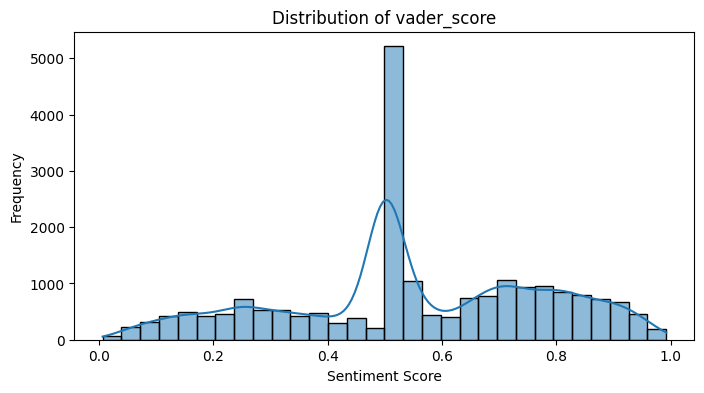

In [ ]:
# ========== Distribution of Sentiment Scores ==========
sentiment_cols = ['bertweet_score', 'cardiff_score', 'vader_score']

for col in sentiment_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Frequency')
    plt.show()


### **cardiff_score** shows a more natural and balanced distribution of sentiment scores, which makes it more reliable for capturing subtle sentiment variations.

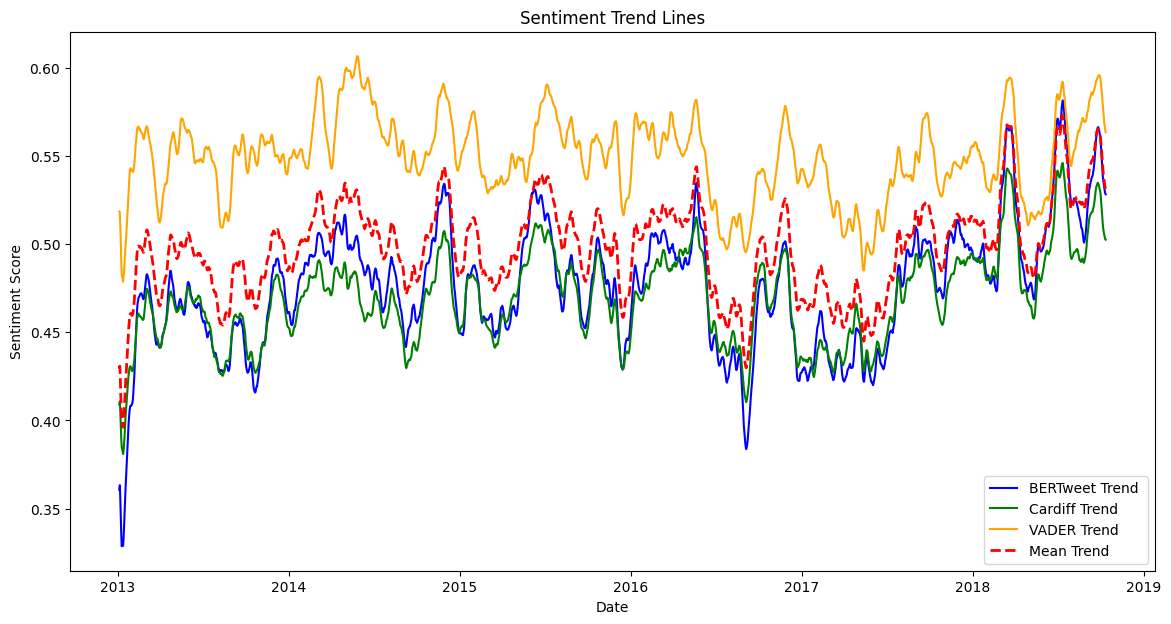

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Resample to daily average
daily_sentiment = df.resample('D')[['bertweet_score', 'cardiff_score', 'vader_score']].mean()

# Decompose and extract trends
trends = {}
for col in ['bertweet_score', 'cardiff_score', 'vader_score']:
    series = daily_sentiment[col].dropna()
    result = seasonal_decompose(series, model='additive', period=7)
    trends[col] = result.trend

# Create a DataFrame for trends
trend_df = pd.DataFrame(trends)

# Smooth with a 30-day moving average
smooth_trend_df = trend_df.rolling(window=30,min_periods=1).mean()
smooth_trend_df['mean_trend'] = smooth_trend_df.mean(axis=1)

# Plot smoothed trends
plt.figure(figsize=(14, 7))
plt.plot(smooth_trend_df.index, smooth_trend_df['bertweet_score'], label='BERTweet Trend ', color='blue')
plt.plot(smooth_trend_df.index, smooth_trend_df['cardiff_score'], label='Cardiff Trend', color='green')
plt.plot(smooth_trend_df.index, smooth_trend_df['vader_score'], label='VADER Trend ', color='orange')
plt.plot(smooth_trend_df.index, smooth_trend_df['mean_trend'], label='Mean Trend', color='red', linestyle='--', linewidth=2)

plt.title('Sentiment Trend Lines')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend()
plt.show()

###   **CardiffNLP score** offers more grounded and realistic sentiment shifts.Cardiff Score Trend closely aligns with both the BERTweet and Mean Trend . Unlike VADER, which often overestimates sentiment with exaggerated spikes.


# Sentiment Trend of CardiffNLP score

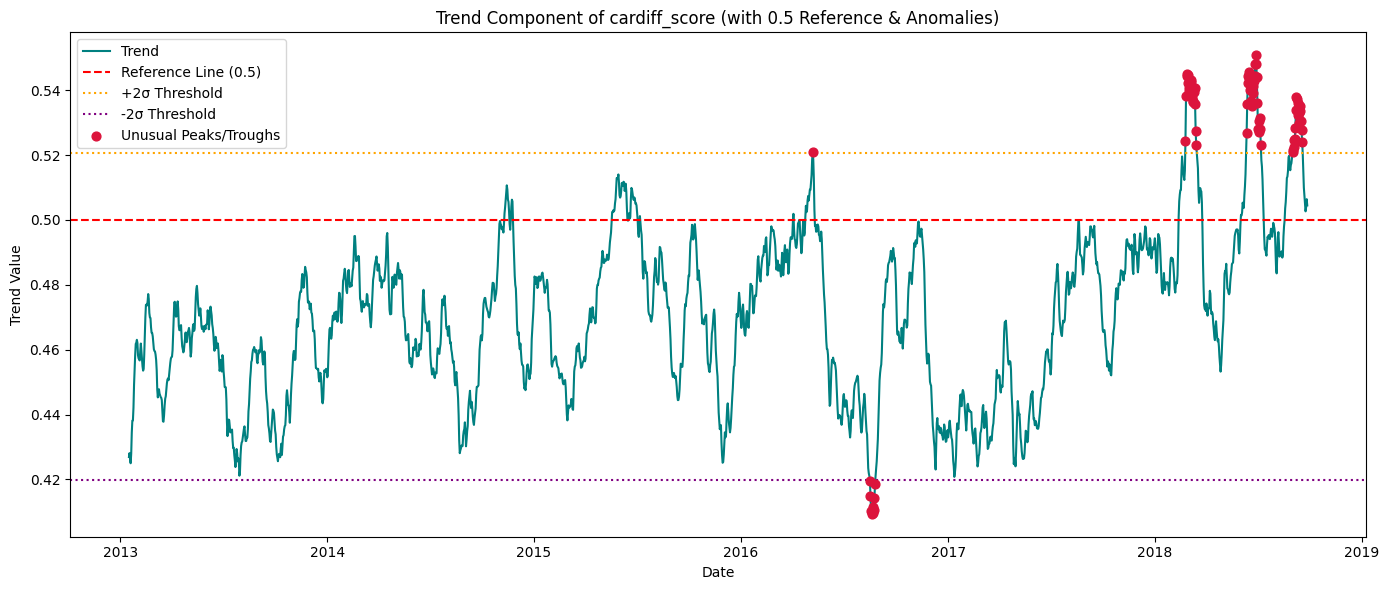

In [ ]:
# Resample to daily frequency
daily_cardiff = df['cardiff_score'].resample('D').mean().interpolate()

# Decompose to extract the trend component
decomp = seasonal_decompose(daily_cardiff, model='additive', period=30)
trend = decomp.trend.dropna()

# Calculate thresholds for anomaly detection
mean = trend.mean()
std = trend.std()
upper = mean + 2 * std
lower = mean - 2 * std
reference = 0.5

# Detect anomalies
anomalies = (trend > upper) | (trend < lower)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(trend, label='Trend', color='teal')
plt.axhline(reference, color='red', linestyle='--', label='Reference Line (0.5)')
plt.axhline(upper, color='orange', linestyle=':', label='+2σ Threshold')
plt.axhline(lower, color='purple', linestyle=':', label='-2σ Threshold')

# Anomalies
plt.scatter(trend[anomalies].index, trend[anomalies], color='crimson', s=40, label='Unusual Peaks/Troughs', zorder=5)

plt.title('Trend Component of cardiff_score (with 0.5 Reference & Anomalies)')
plt.xlabel('Date')
plt.ylabel('Trend Value')
plt.legend()
plt.tight_layout()
plt.show()


### Demonetisation (**Nov 2016**): A major dip appears around late 2016, due to the sudden demonetisation, which sparked strong public reactions.

### **Early 2018** Budget and Elections: Another fluctuation is seen in early 2018, linked to the Union Budget announcements which stirred public debate on key issues.

# Actual Sentiment Score and forecasted Sentiment Score by different Forecasting Models

              Model       SMAPE           MSE         MAE  Training Time (s)
0             Arima   35.809497      0.050681    0.169826             1530.0
1               GRU   32.000565      0.044787    0.153793              256.0
2               RNN  200.006653  13418.665039  115.838760             1880.2
3  Informer_metrics   32.574615      0.045489    0.154487             1371.0
4              LSTM   32.767456      0.046798    0.157491              230.8
5           PRTPlus   32.329964      0.045859    0.156022             2224.1


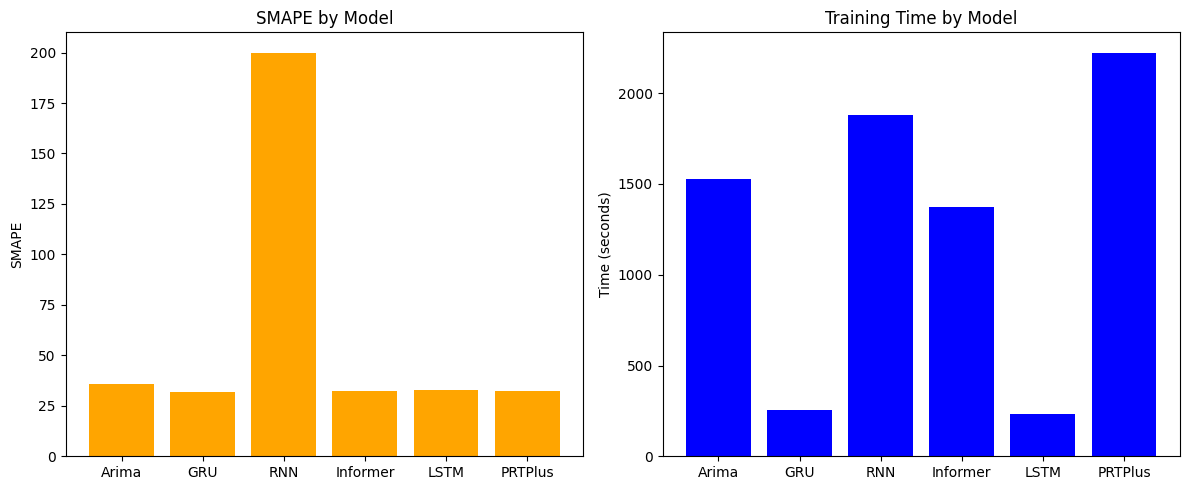

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import re

def convert_time_to_seconds(time_str):
    match = re.match(r"(?:(\d+)m\s*)?(?:(\d+(?:\.\d+)?)s)?", time_str)
    if not match:
        return None
    minutes = int(match.group(1)) if match.group(1) else 0
    seconds = float(match.group(2)) if match.group(2) else 0
    return minutes * 60 + seconds

# Load all model JSONs
file_paths = [
    "/content/Arima.json",
    "/content/GRU.json",
    "/content/RNN.json",
    "/content/Informer_metrics.json",
    "/content/LSTM.json",
    "/content/PRTPlus.json"
]

model_metrics = []

# Extract final losses and training time
for path in file_paths:
    with open(path, 'r') as f:
        data = json.load(f)
        model_name = path.split('/')[-1].replace('.json', '')
        smape = data["final_losses"]["smape"]
        mse = data["final_losses"]["mse"]
        mae = data["final_losses"]["mae"]
        train_time_sec = convert_time_to_seconds(data["Training time"])

        model_metrics.append({
            "Model": model_name,
            "SMAPE": smape,
            "MSE": mse,
            "MAE": mae,
            "Training Time (s)": train_time_sec
        })

# Create DataFrame
df_metrics = pd.DataFrame(model_metrics)

print(df_metrics)

df_metrics["Model"] = df_metrics["Model"].replace("Informer_metrics", "Informer")

#plot
plt.figure(figsize=(12, 5))

# SMAPE
plt.subplot(1, 2, 1)
plt.bar(df_metrics["Model"], df_metrics["SMAPE"], color='orange')
plt.title("SMAPE by Model")
plt.ylabel("SMAPE")
plt.xticks()

# Training Time
plt.subplot(1, 2, 2)
plt.bar(df_metrics["Model"], df_metrics["Training Time (s)"], color='blue')
plt.title("Training Time by Model")
plt.ylabel("Time (seconds)")
plt.xticks()

plt.tight_layout()
plt.show()


### While PRTPlus achieves a comparable SMAPE, it comes at a very high computational cost, taking the longest training time among all models. In contrast, models like **GRU , Informer**  deliver comparably same SMAPE performance with significantly lower training time, making them more practical and efficient choices.


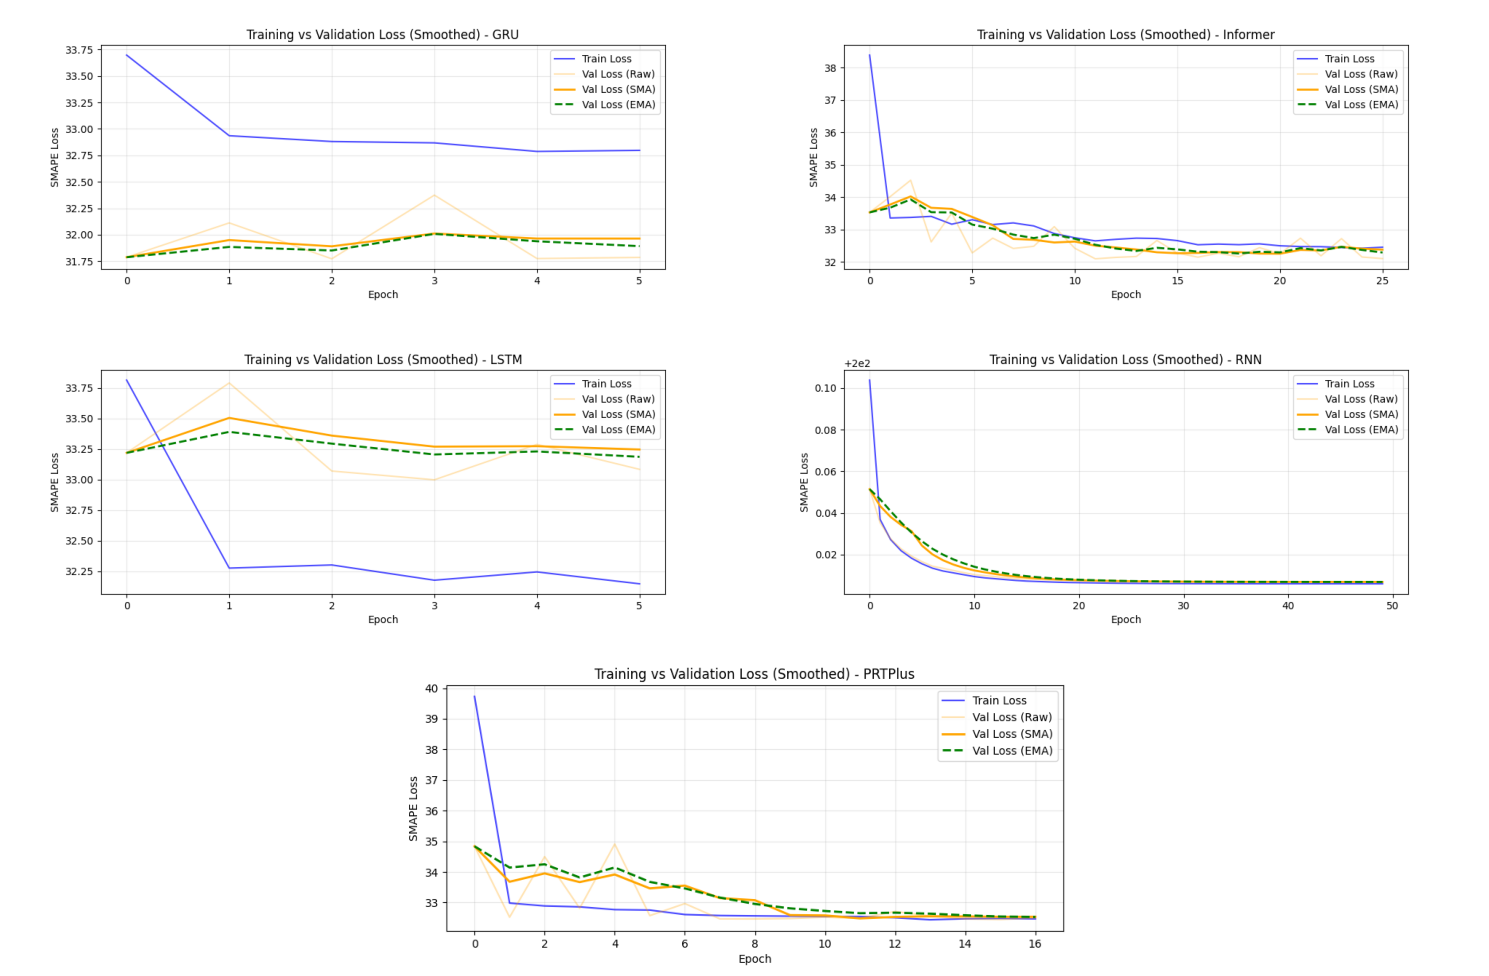

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

image_files = [
    '/content/GRU_loss_smape.png',
    '/content/Informer_loss_smape.png',
    '/content/LSTM_loss_smape.png',
    '/content/RNN_loss_smape.png',
    '/content/PRTPlus_loss_smape.png'
]

fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, :])

for ax, img_file, title in zip([ax1, ax2, ax3, ax4, ax5], image_files, range(1, 6)):
    img = mpimg.imread(img_file)
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()


### Among the five models, the Informer demonstrates the best overall performance with highly stable training and consistent validation loss improvement.

### Then , GRU and LSTM both show consistent training .

### RNN model, while exhibiting very smooth loss curve, but hight loss scale than other making comparison unreliable.

### PRTPlus shows stable training with some early validation fluctuation.

### Overall, **Informer** stands out as the most stable and well-generalized model among the group.










# Actual CardiffNLP Sentiment trend and Forecasted sentiment trend by Informer

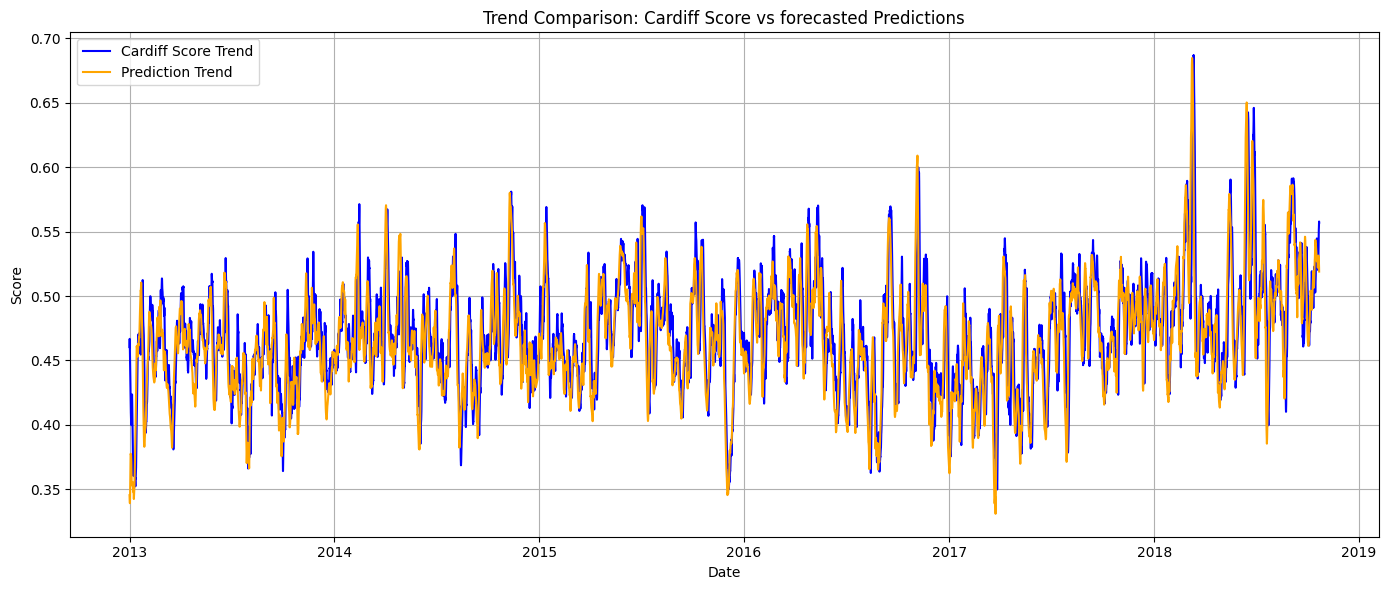

In [ ]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

#  Load CSV
csv_df = pd.read_csv("/content/reshaped_all_tweet_score(2013-2018).csv")
csv_df['datetime'] = pd.to_datetime(csv_df['datetime'])

# Load JSON
with open("/content/Informer.json", 'r') as f:
    json_data = json.load(f)

predictions = json_data["predictions"]

#  ensure Aligned lengths
min_len = min(len(csv_df), len(predictions))
csv_df = csv_df.iloc[:min_len]
predictions = predictions[:min_len]

# Combine into DataFrame
df = pd.DataFrame({
    'datetime': csv_df['datetime'].values,
    'cardiff_score': csv_df['cardiff_score'].values,
    'prediction': predictions
})
df.set_index('datetime', inplace=True)

# Seasonal Decomposition
decompose_cardiff = seasonal_decompose(df['cardiff_score'], model='additive', period=7)
decompose_prediction = seasonal_decompose(df['prediction'], model='additive', period=7)

trend_cardiff_smooth = decompose_cardiff.trend.rolling(window=60, center=True, min_periods=1).mean()
trend_prediction_smooth = decompose_prediction.trend.rolling(window=60, center=True, min_periods=1).mean()

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(trend_cardiff_smooth, label='Cardiff Score Trend', color='blue')
plt.plot(trend_prediction_smooth, label='Prediction Trend ', color='orange')
plt.title('Trend Comparison: Cardiff Score vs forecasted Predictions')
plt.xlabel('Date')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
